In [1]:
contributor = "Lina"

#### Step 1: Import Libraries

In [2]:
import json
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
from pandarallel import pandarallel
import matplotlib.pyplot as plt
pandarallel.initialize(progress_bar=True)
import pytz

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Step 2: Load and Preprocess Data

In [2]:
# # Load the JSON file
# data = []
# with open('clean_trips.json', 'r') as file:
#     for line in file:
#         data.append(json.loads(line))

# df = pd.DataFrame(data)

# # Calculate trip time in seconds
# df['trip_time'] = df['time']

# # Drop rows with missing values (if any)
# df.dropna(inplace=True)

In [37]:
# Directory and file name pattern
directory = '/Users/linaserry/Desktop/thesis/eta/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(28, 32)]

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [38]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Drop rows with missing values (if any)
df.dropna(inplace=True)

#### Step 3: Prepare Features and Target

In [127]:
# Feature extraction functions
def extract_features(row):
    features = {}
    features['mean_time_gap'] = np.mean(row['time_gap'])
    features['std_time_gap'] = np.std(row['time_gap'])
    features['min_time_gap'] = np.min(row['time_gap'])
    features['max_time_gap'] = np.max(row['time_gap'])
    
    # features['mean_lat'] = np.mean(row['lats'])
    # features['std_lat'] = np.std(row['lats'])
    # features['min_lat'] = np.min(row['lats'])
    # features['max_lat'] = np.max(row['lats'])
    
    # features['mean_lng'] = np.mean(row['lngs'])
    # features['std_lng'] = np.std(row['lngs'])
    # features['min_lng'] = np.min(row['lngs'])
    # features['max_lng'] = np.max(row['lngs'])
    
    features['mean_dist_gap'] = np.mean(row['dist_gap'])
    features['std_dist_gap'] = np.std(row['dist_gap'])
    features['min_dist_gap'] = np.min(row['dist_gap'])
    features['max_dist_gap'] = np.max(row['dist_gap'])
    
    return pd.Series(features)

#### Step 4: Split the Data

In [128]:
# Split the data
split_random_state = 0
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=split_random_state)
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Apply feature extraction to each subset
train_features = X_train.apply(extract_features, axis=1)
test_features = X_test.apply(extract_features, axis=1)

# Combine features with other relevant columns
X_train = pd.concat([train_features, X_train[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)
X_test = pd.concat([test_features, X_test[['driverID', 'weekID', 'timeID', 'dateID', 'trip_time']]], axis=1)

# Convert non-numeric columns to numeric or drop them
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

### Feature engineering trial

In [113]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

def extract_features(row):
    features = {}
    features['mean_time_gap'] = np.mean(row['time_gap'])
    features['std_time_gap'] = np.std(row['time_gap'])
    features['min_time_gap'] = np.min(row['time_gap'])
    features['max_time_gap'] = np.max(row['time_gap'])
    
    features['mean_lat'] = np.mean(row['lats'])
    features['std_lat'] = np.std(row['lats'])
    features['min_lat'] = np.min(row['lats'])
    features['max_lat'] = np.max(row['lats'])
    
    features['mean_lng'] = np.mean(row['lngs'])
    features['std_lng'] = np.std(row['lngs'])
    features['min_lng'] = np.min(row['lngs'])
    features['max_lng'] = np.max(row['lngs'])
    
    features['mean_dist_gap'] = np.mean(row['dist_gap'])
    features['std_dist_gap'] = np.std(row['dist_gap'])
    features['min_dist_gap'] = np.min(row['dist_gap'])
    features['max_dist_gap'] = np.max(row['dist_gap'])
    
    return pd.Series(features)

# Split the data
split_random_state = 0
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=split_random_state)

# Apply feature extraction to each subset
train_features = X_train.apply(extract_features, axis=1)
test_features = X_test.apply(extract_features, axis=1)

# Combine features with other relevant columns
X_train = pd.concat([train_features, X_train[['driverID', 'weekID', 'timeID', 'dateID']]], axis=1)
X_test = pd.concat([test_features, X_test[['driverID', 'weekID', 'timeID', 'dateID']]], axis=1)

# Convert non-numeric columns to numeric or drop them
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

# Extract only feature columns for model fitting and feature selection
feature_columns = train_features.columns

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train[feature_columns], y_train)

# Feature selection
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train[feature_columns])
X_test_selected = selector.transform(X_test[feature_columns])

# Train the model again on the selected features
model.fit(X_train_selected, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

# Print the selected feature indices
selected_features = feature_columns[selector.get_support()]
print(f'Selected features: {selected_features}')


Root Mean Squared Error (RMSE): 0.6589486919137836


IndexError: boolean index did not match indexed array along dimension 0; dimension is 16 but corresponding boolean dimension is 1

In [129]:
print(X_train.shape)
print(X_train_selected[0])

(18567, 13)
[996.]


### Step 5: Hyperparameter Tuning and Model Training

##### Parameter Grid Search

In [48]:
# param_grid = {
#     'n_estimators': list(range(1, 202, 50)),
#     'max_depth': list(range(1, 8)),
#     'min_samples_leaf': list(range(1, 10)),
#     'max_leaf_nodes': [None] + list(range(10, 20, 2)),
#     'random_state': [42],
#     'criterion': ['mse', 'absolute_error']
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring='neg_root_mean_squared_error')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# model = RandomForestRegressor(**best_params)
# model.fit(X_train, y_train)

Fitting 5 folds for each of 3780 candidates, totalling 18900 fits


KeyboardInterrupt: 

#### Parameter Random Search

In [50]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [51]:
model = RandomForestRegressor()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  44.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  44.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  49.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000

/Users/linaserry/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  52.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  53.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  53.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  33.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  33.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.2min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.2min
[CV] END bootstrap=False, max_dep

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [52]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

##### Narrow down the parameter grid search

#### Evaluate parameter performance

In [60]:
#baseline model parameters
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    # print('Model Performance')
    # print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    # print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

Model Performance
Average Error: 0.2886 degrees.
Accuracy = 99.99%.


##### Only one parameter

In [143]:
# # Best parameters based on random search
# n_estimators = 1400
# max_depth = 40  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
# min_samples_leaf = 1  # The minimum number of samples required to be at a leaf node
# max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
# # random_state = 42  # Ensures reproducibility
# # criterion = 'squared_error'  # Default criterion for regression tasks
# criterion = 'mse'  # works for Lina's version
# max_features = 'auto'  # Consider sqrt of the number of features for each split
# min_samples_split = 2  # The minimum number of samples required to split an internal node
# bootstrap = False  # Use the whole dataset for each tree

# simpler version of the model
n_estimators = 100
max_depth = 8  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_leaf = 10  # The minimum number of samples required to be at a leaf node
max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
# criterion = 'squared_error'  # Default criterion for regression tasks
criterion = 'mse'  # works for Lina's version
max_features = 'auto'  # Consider sqrt of the number of features for each split
min_samples_split = 20  # The minimum number of samples required to split an internal node
bootstrap = True  # Use the whole dataset for each tree

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    criterion=criterion,
    max_features=max_features,
    min_samples_split=min_samples_split,
    bootstrap=bootstrap
)

model.fit(X_train.drop(columns=['trip_time']), y_train)
# model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test.drop(columns=['trip_time']))
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 4.793012462033326


#### Step 6: Evaluate the Model with Learning Curves

In [144]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-07-03T02:34:27
Model_Run_20240703T023427


In [85]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_{label}.png')

# Save the figure
fig.write_image(output_file)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


#### Step 7: Make Predictions and Calculate Errors

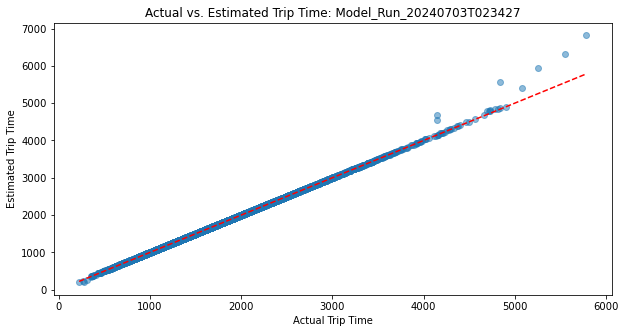

Mean Absolute Error (MAE): 1.5098056847983776
R^2 Score: 0.9988680512062477


In [145]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_{label}.png')
    plt.savefig(output_file)
    plt.show()
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

### Detecting overfitting

In [146]:
#Compare training and testing metrics

# Evaluate on the training data
train_df = estimations(X_train, model, feature_names)
print("Training Data Metrics:")
# plot_graphs(train_df, label="Training Data")
train_mae, train_r2 = get_metrics(train_df)

# Evaluate on the test data
test_df = estimations(X_test, model, feature_names)
print("Test Data Metrics:")
# plot_graphs(test_df, label="Test Data")
test_mae, test_r2 = get_metrics(test_df)

# Compare the metrics
print(f"Training MAE: {train_mae}, Training R^2: {train_r2}")
print(f"Test MAE: {test_mae}, Test R^2: {test_r2}")


Training Data Metrics:
Mean Absolute Error (MAE): 1.4133350219623306
R^2 Score: 0.9988240773371603
Test Data Metrics:
Mean Absolute Error (MAE): 1.8034026057994486
R^2 Score: 0.9985653961880565
Training MAE: 1.4133350219623306, Training R^2: 0.9988240773371603
Test MAE: 1.8034026057994486, Test R^2: 0.9985653961880565


In [148]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_train.drop(columns=['trip_time']), y_train, cv=10, scoring='neg_mean_absolute_error')

# Convert negative MAE to positive
cv_scores = -cv_scores

print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Average Cross-Validation MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of Cross-Validation MAE: {np.std(cv_scores)}')


Cross-Validation MAE Scores: [1.08914932 1.26392321 1.23949619 2.4406117  1.45119521 1.87333813
 1.07044069 1.54434501 1.68464282 7.4770723 ]
Average Cross-Validation MAE: 2.113421457892292
Standard Deviation of Cross-Validation MAE: 1.8303557421570276


#### Step 8: Log the results

In [140]:
# Define the log file path
log_file_path = 'model_training_results_log.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor', 'split_random_state'])

def log_model_training(split_random_state,n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor, split_random_state])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(split_random_state, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)


In [141]:
log_file_path = 'feature_engineering_results_log.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'Features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_feature_engineering(features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, features, RMSE, MAE, R2_Score, input_data_files, contributor])


features = ', '.join(X_train.columns.tolist())
log_feature_engineering(features, rmse, mae, r2, input_data_files)